In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist
from rsc_functions.utility.rank_genes_groups import return_markers,rank_genes_groups
from rsc_functions.reports.plot import plot_expression

KeyboardInterrupt: 

In [2]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 

In [3]:
path_xenium = os.path.join(path,"cell_feature_matrix.h5")
path_cells = os.path.join(path,"cells.zarr.zip")
adata = sc.read_10x_h5(path_xenium)
rsc.get.anndata_to_GPU(adata)
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="mt-")
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT"])
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path))
    return zarr.group(store=store)
root = open_zarr(path_cells)
column_names = dict(root['cell_summary'].attrs.items())['column_names']
def build_obs(andata,root,column_names):
    for i in range(len(column_names)):
        andata.obs[str(column_names[i])] = np.array(root["cell_summary"])[:,i]
    spatial = andata.obs[["cell_centroid_x", "cell_centroid_y"]]
    adata.obsm["spatial"] = spatial.values
    return andata
andata = build_obs(adata,root,column_names)
andata.var_names_make_unique()
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="mt-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])


In [4]:
andata

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    uns: 'config'
    obsm: 'spatial'

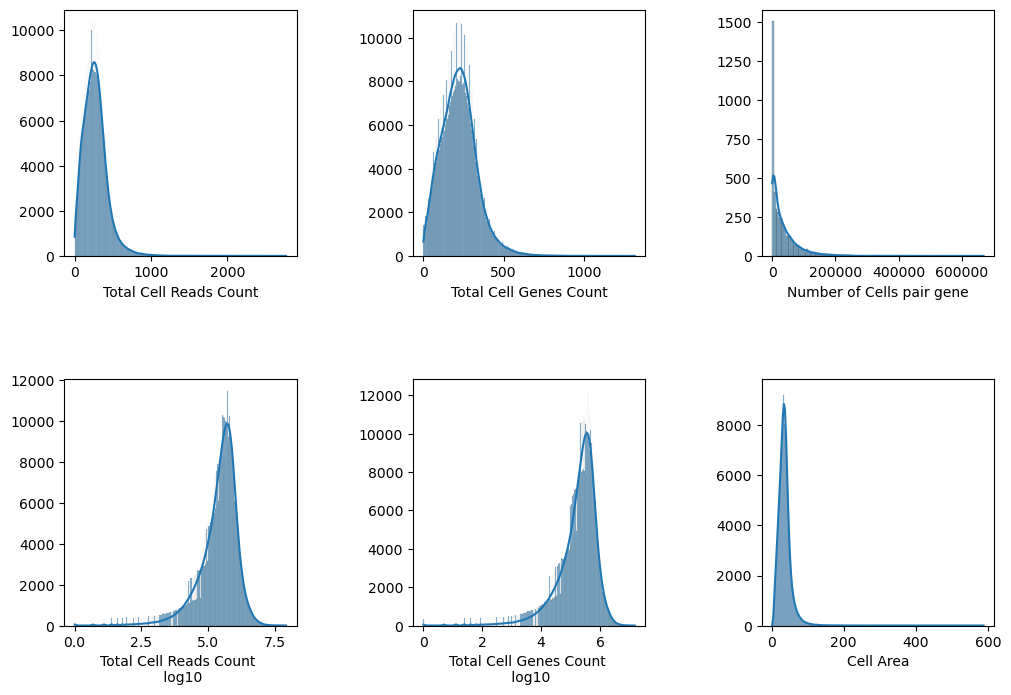

In [5]:
import warnings

# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    plot_dist(andata,column = 'cell_area',ax = ax[5],xlab = 'Cell Area')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

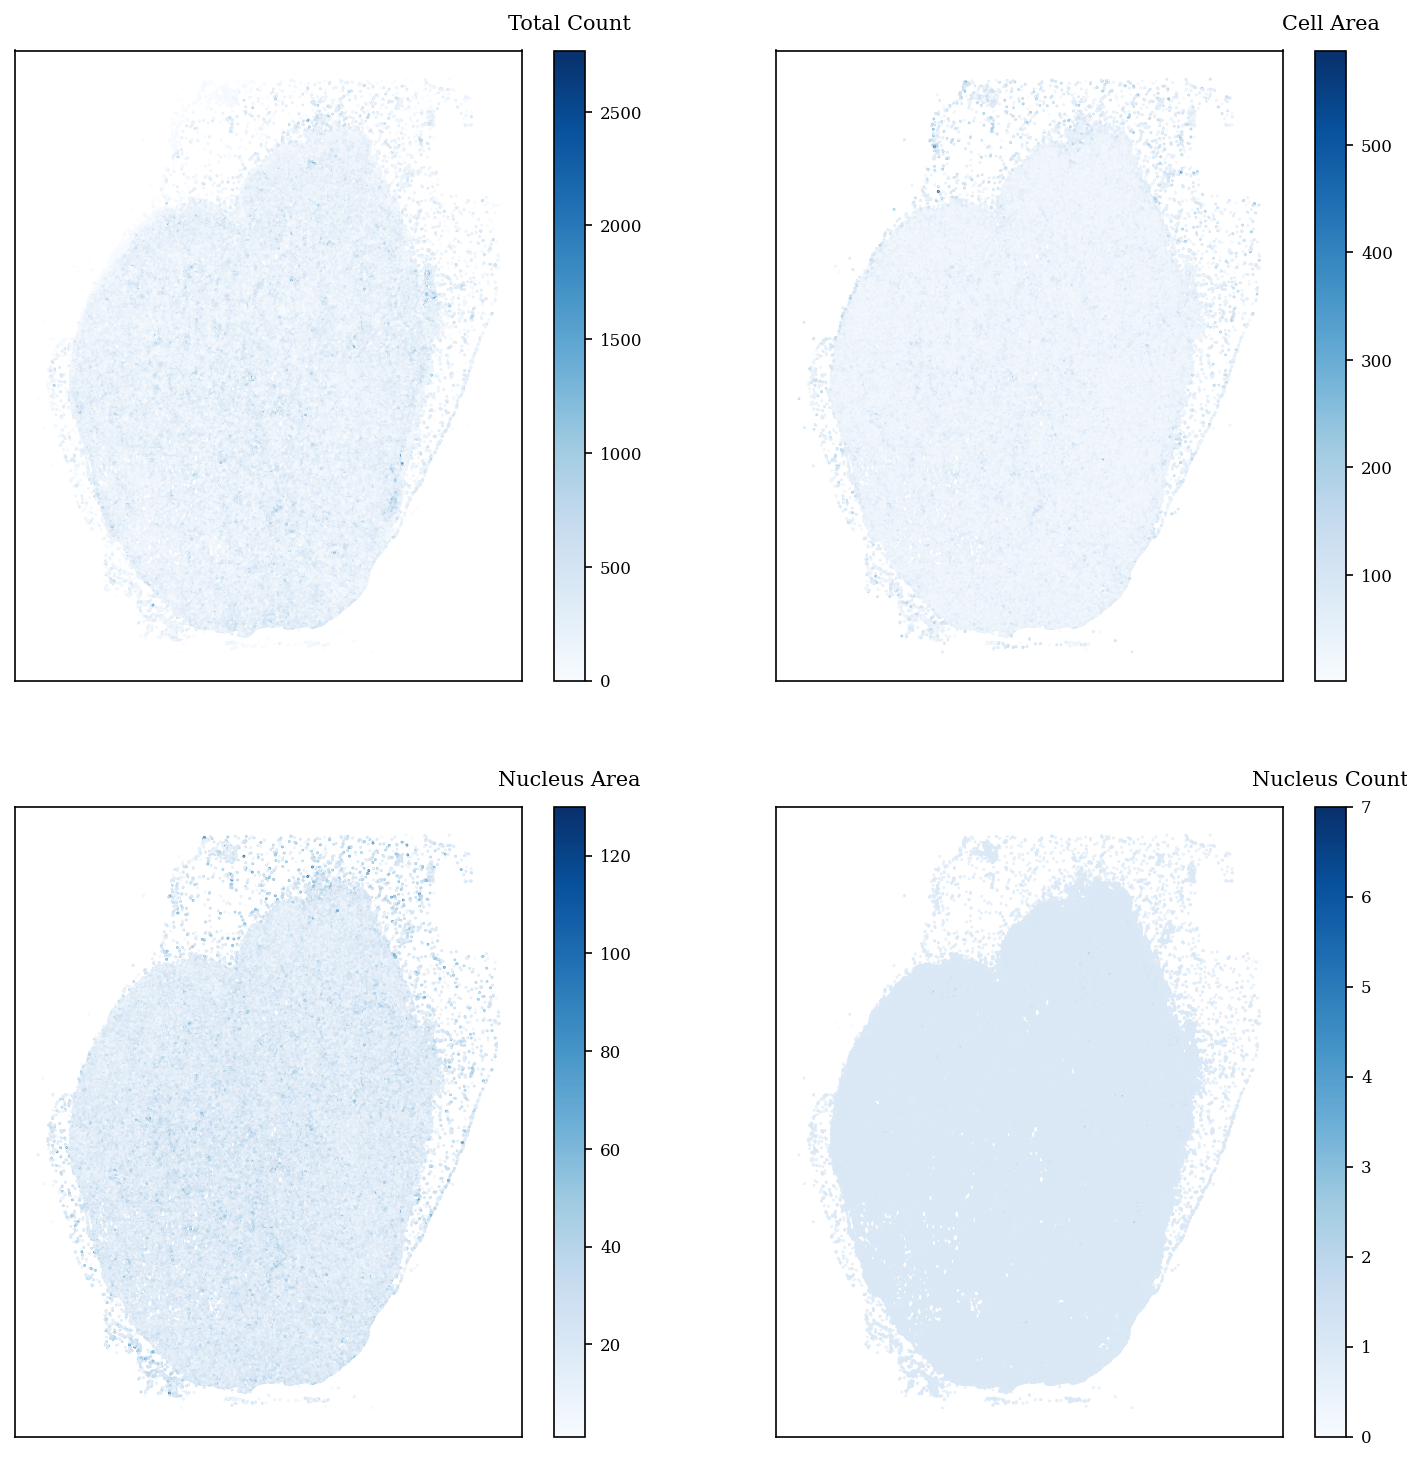

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.ravel()
plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax[0],set_xlabel_cbar = 'Total Count',size = 0.1)
plot_spatial_data(andata, 'cell_area', fig = fig, ax = ax[1],set_xlabel_cbar = 'Cell Area',size = 0.1)
plot_spatial_data(andata, 'nucleus_area', fig = fig , ax = ax[2],set_xlabel_cbar = 'Nucleus Area',size = 0.1)
plot_spatial_data(andata, 'nucleus_count', fig = fig , ax = ax[3],set_xlabel_cbar = 'Nucleus Count',size = 0.1)

In [7]:
rsc.pp.filter_cells(andata, min_count=10,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=5)
rsc.pp.filter_genes(andata, max_count=200_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=1500, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)


filtered out 3685 cells
filtered out 1 genes based on n_cells_by_counts
filtered out 53 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [ ]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [10]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)
rsc.tl.leiden(andata, random_state=1337, resolution=0.5, key_added='cluster') 

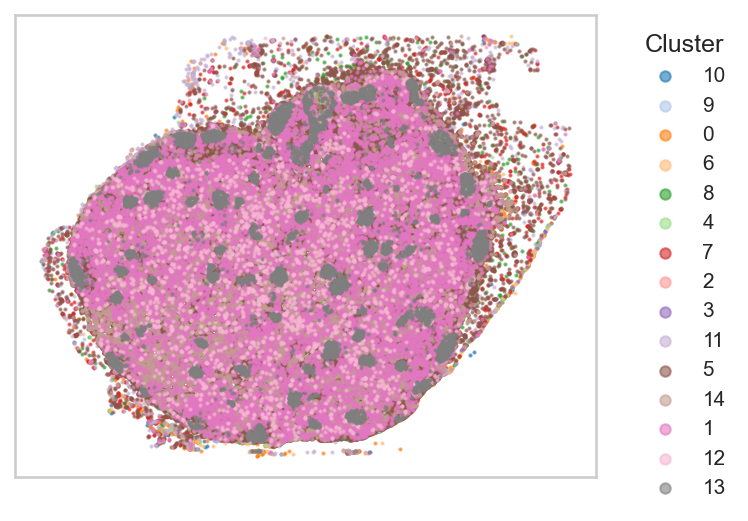

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_spatial(andata,ax = ax, features = None, title = '', xlab = '',ylab ='',size = 0.5)

In [12]:
rsc.tl.umap(andata, min_dist=0.3)

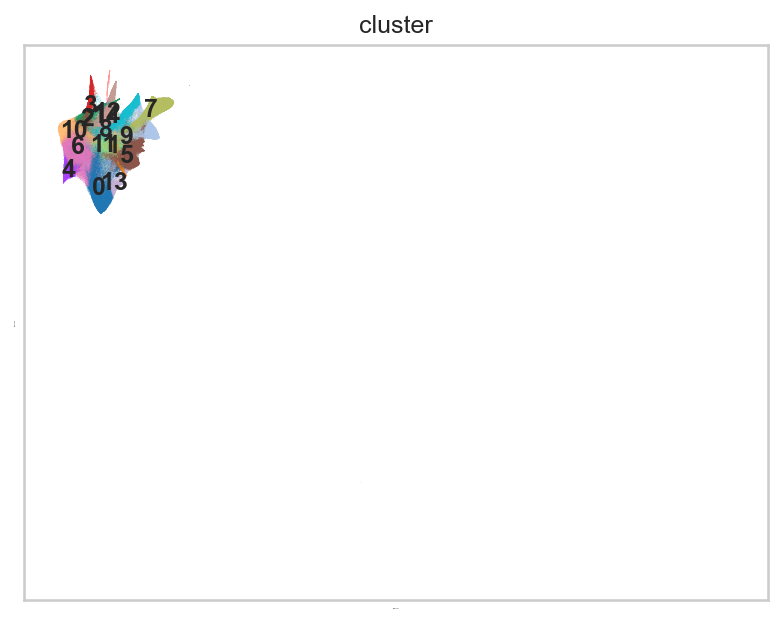

In [13]:
sc.pl.umap(andata, color=['cluster'], legend_loc="on data")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_sing

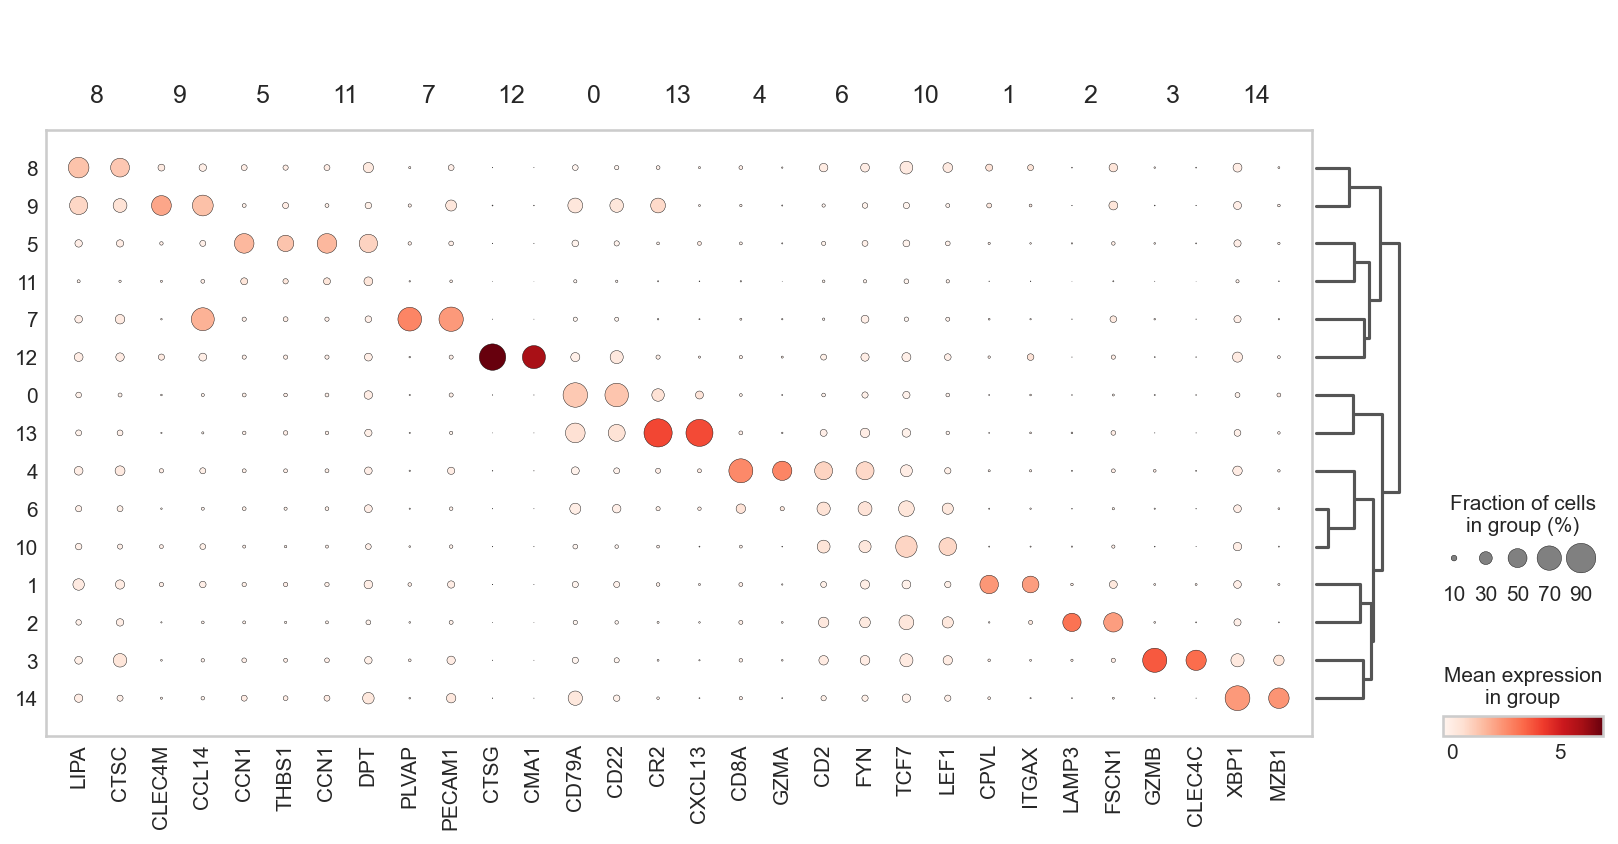

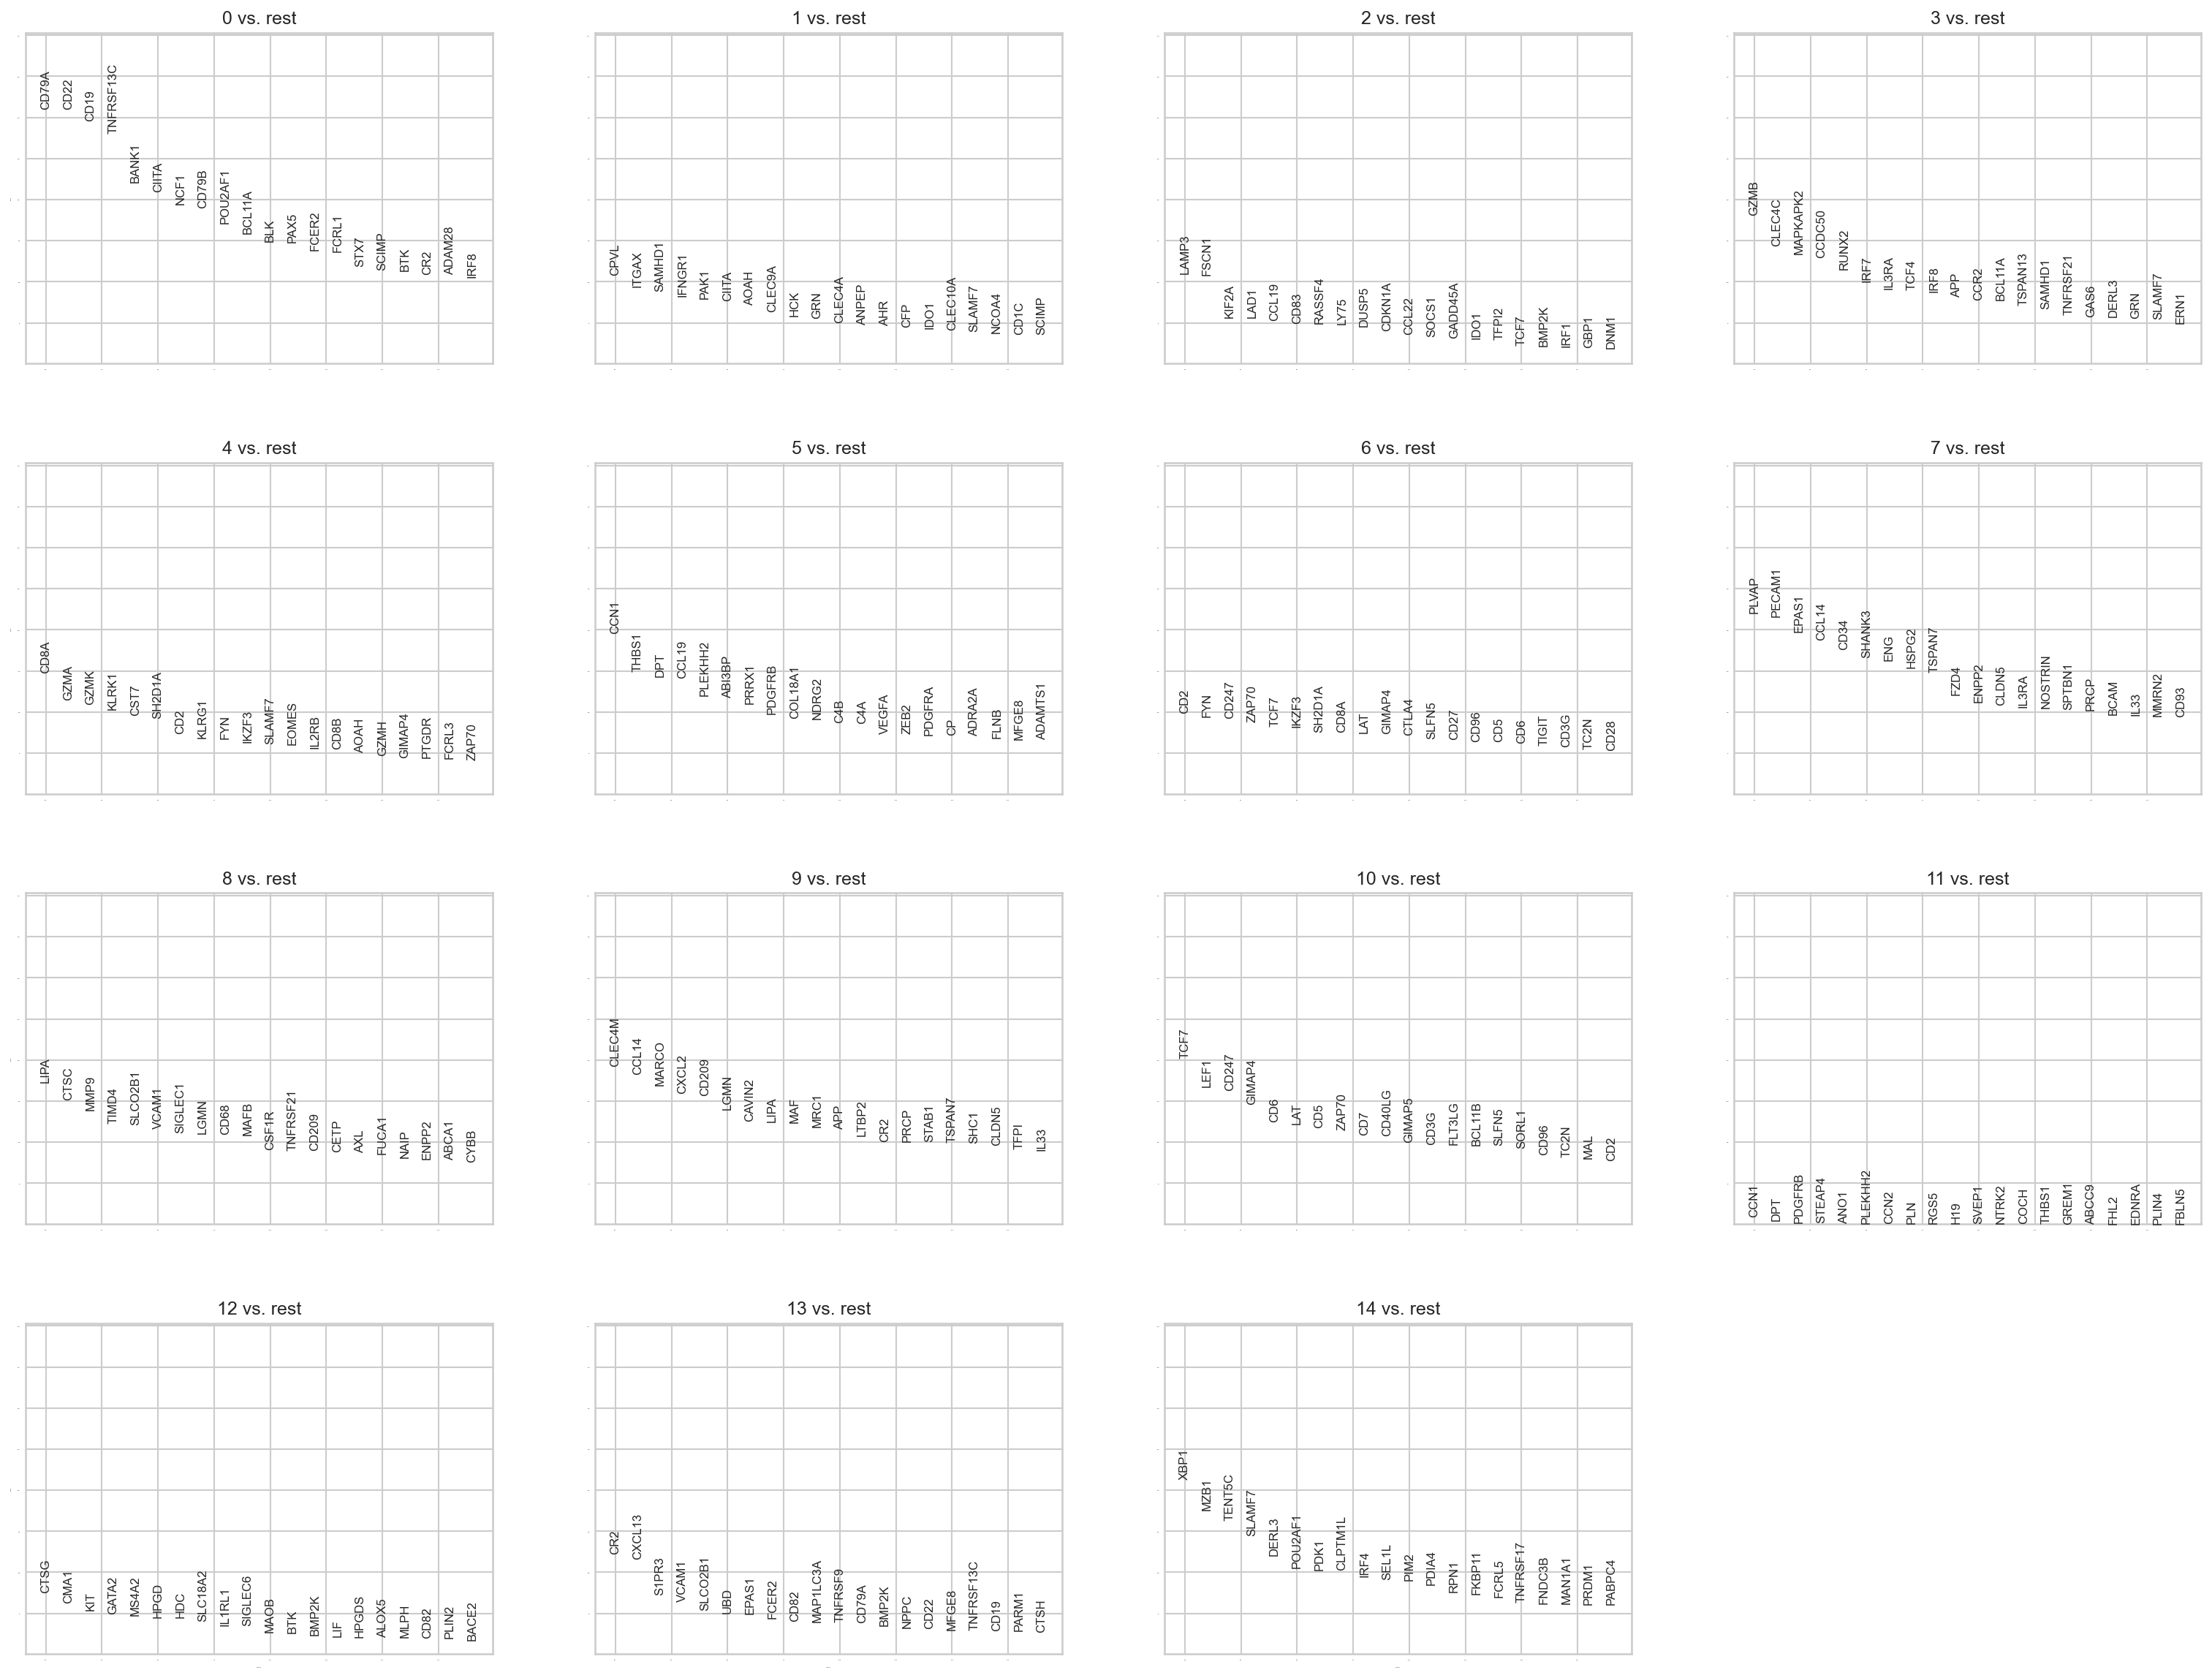

In [14]:
rsc.get.anndata_to_CPU(andata)
sc.tl.rank_genes_groups(andata, groupby="cluster", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(andata, groupby="cluster",n_genes=2)
sc.pl.rank_genes_groups(andata, n_genes=20)

In [15]:
import squidpy as sq
sq.gr.spatial_neighbors(andata, coord_type="generic",delaunay = True)
sq.gr.nhood_enrichment(andata, cluster_key="cluster")

IOStream.flush timed out
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.11/s]


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


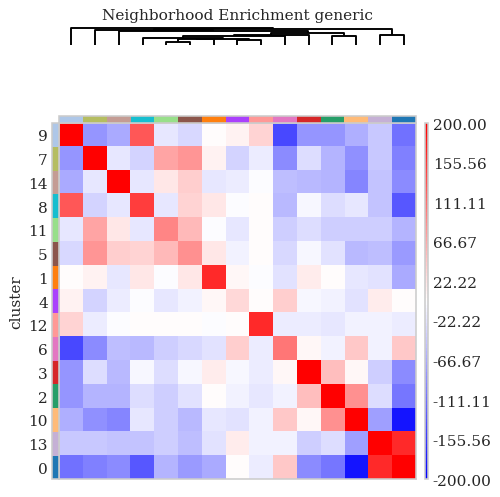

In [16]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
n_bins = 100  # Discretize into 100 bins
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sq.pl.nhood_enrichment(
    andata,
    title = "Neighborhood Enrichment generic",
    cluster_key="cluster",
    method="average",
    cmap=custom_cmap,
    vmin=-200,
    vmax=200,
    figsize=(5, 5),
)

Save Matrices - knn Distance and Connectivities

In [17]:
import cupy as cp
from cupyx.scipy.sparse import csr_matrix 

In [18]:
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape) 
       

In [19]:
sparse_matrix = andata.obsp['distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_distances_large.npz")

In [20]:
sparse_matrix = andata.obsp['connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_connectivities_large.npz")

In [21]:
andata_save = andata.copy()
andata_save.X = andata_save.layers['log']
del andata_save.uns
# del andata_save.obsm
del andata_save.varm
del andata_save.layers
del andata_save.obsp
andata_save.write_h5ad(os.path.join(pathout, "andata_save.h5ad"))

<center><h4> cupy load andta stlearn</center>
<sh>mamba activate stlearn-env</sh>

In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import stlearn as st
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image

/gpfs/gsfs10/users/kanferg/conda/envs/stlearn-env/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 
andata = sc.read_h5ad(os.path.join(pathout, "andata_save.h5ad"))

In [3]:
andata

AnnData object with n_obs × n_vars = 705298 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_umap', 'spatial'

In [4]:
def load_matrix(andata,pathout,npz_file = "obsp_distances.npz",mode = 'sparse', mat_name = 'distances'):
    npzfile = cp.load(os.path.join(pathout, npz_file))
    data = cp.array(npzfile['data'])
    indices = cp.array(npzfile['indices'])
    indptr = cp.array(npzfile['indptr'])
    shape = tuple(npzfile['shape'])
    
    # Reconstruct the sparse matrix
    sparse_matrix_distances = csr_matrix((data, indices, indptr), shape=shape)
    if mode== 'sparse':
        andata.obsp[mat_name] = sparse_matrix_distances
    else:
        andata.obsp[mat_name] = sparse_matrix_distances.get()
    return andata

In [5]:
andata = load_matrix(andata,pathout,npz_file = "obsp_connectivities_large.npz",mode = 'sparse', mat_name = 'distances')
andata = load_matrix(andata,pathout,npz_file = "obsp_distances_large.npz",mode = 'sparse', mat_name = 'connectivities')

Prepare the andata to stLearn application

In [6]:
andata.obs["imagerow"] = andata.obs["cell_centroid_x"]
andata.obs["imagecol"] = andata.obs["cell_centroid_y"]
andata.uns["spatial"] = andata.obsm["spatial"]
def make_uns_spatial(adata):
    max_size = np.max([adata.obs["imagerow"].max(), adata.obs["imagecol"].max()])
    max_size = int(max_size + 0.1 * max_size)
    image = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
    imgarr = np.array(image)
    adata.uns["spatial"] = {}
    adata.uns["spatial"]["id1"] = {}
    adata.uns["spatial"]["id1"]["images"] = {}
    adata.uns["spatial"]["id1"]["images"]["lowres"] = imgarr
    adata.uns["spatial"]["id1"]["use_quality"] = "lowres"
    adata.uns["spatial"]["id1"]["scalefactors"] = {}
    adata.uns["spatial"]["id1"]["scalefactors"]["tissue_low_scalef" ] = 1
    adata.uns["spatial"]["id1"]["scalefactors"]["spot_diameter_fullres"] = 15
    adata.uns["spatial"]["id1"]["scalefactors"][
            "tissue_" + "lowres" + "_scalef"
        ] = 1
    return adata
andata = make_uns_spatial(andata)

In [7]:
### Calculating the number of grid spots we will generate
n_ = 250
print(f'{n_} by {n_} has this many spots:\n', n_*n_)

250 by 250 has this many spots:
 62500


In [8]:
### Gridding.
grid = st.tl.cci.grid(andata, n_row=n_, n_col=n_, use_label = 'cluster')
print( grid.shape ) # Slightly less than the above calculation, since we filter out spots with 0 cells.

Gridding...
(35389, 1500)


In [9]:
grid

AnnData object with n_obs × n_vars = 35389 × 1500
    obs: 'imagecol', 'imagerow', 'n_cells', 'cluster'
    uns: 'spatial', 'cluster', 'grid_counts', 'grid_xedges', 'grid_yedges'
    obsm: 'spatial'

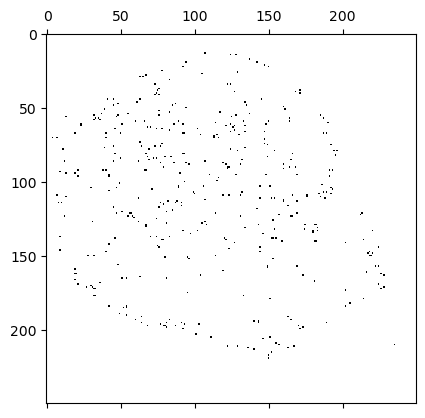

In [47]:
from matplotlib import pyplot as plt
plt.spy(grid.uns['grid_counts']==11)

In [107]:
df_andata = pd.DataFrame({'cluster':andata.obs['cluster'],'x':andata.obsm['spatial'][:,0],'y':andata.obsm['spatial'][:,1]}).reset_index()
df_andata.sample(frac=0.1, replace=False, random_state=1)
len(df_andata)

705298

In [133]:
random.shuffle(palette)

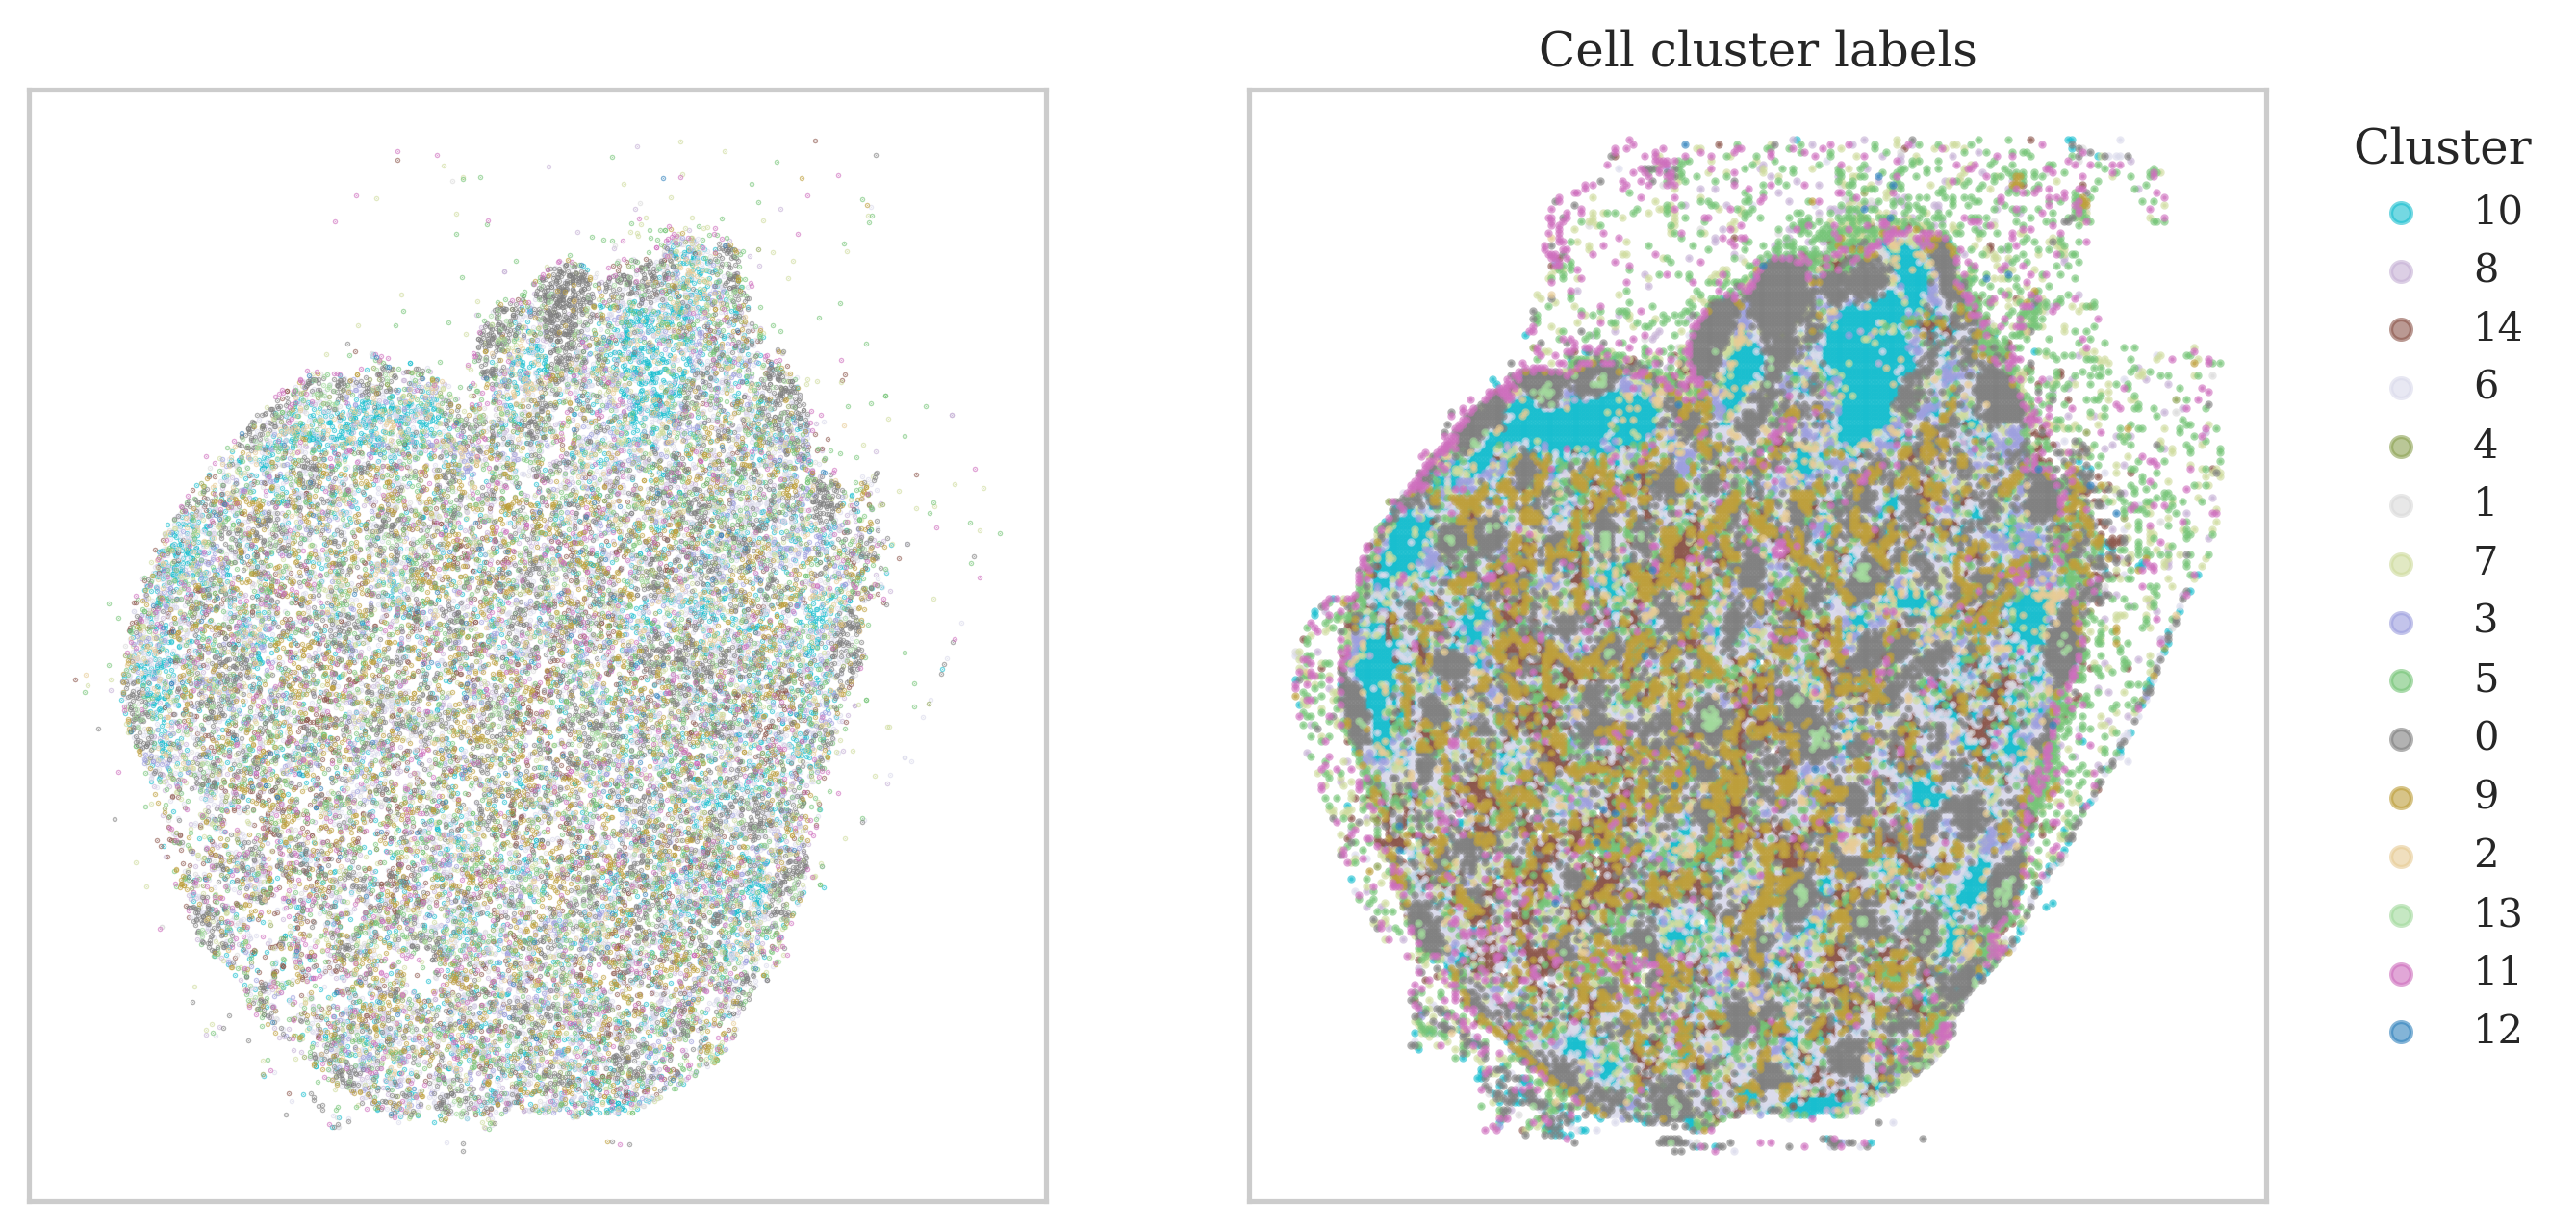

In [135]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import random
import pandas as pd

df_andata = pd.DataFrame({'cluster':andata.obs['cluster'],'x':andata.obsm['spatial'][:,0],'y':andata.obsm['spatial'][:,1]}).reset_index()
df_grid = pd.DataFrame({'cluster':grid.obs['cluster'],'x':grid.obsm['spatial'][:,0],'y':grid.obsm['spatial'][:,1]}).reset_index()

df_andata = df_andata.sample(frac=0.05, replace=True, random_state=1)

palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")
random.shuffle(palette)
# num_classes = len(df_andata['cluster'].unique())
# extended_palette = palette * (num_classes // len(palette) + 1)
# extended_palette = extended_palette[:num_classes]
# listed_cmap = ListedColormap(extended_palette)

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, cluster in enumerate(df_andata['cluster'].unique()):
    cluster_andata = df_andata[df_andata['cluster'] == cluster]
    cluster_grid = df_grid[df_grid['cluster'] == cluster]
    axes[0].scatter(x=cluster_andata['x'], y=cluster_andata['y'], color=palette[i], label=f'{cluster}', s=0.1, alpha=0.6)
    axes[1].scatter(x=cluster_grid['x'], y=cluster_grid['y'], color=palette[i], label=f'{cluster}', s=1, alpha=0.6)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

axes[1].set_title(f'Cell cluster labels')
axes[1].set_title(f'Grid cluster dominant spots')
legend1 = axes[1].legend( title="Cluster",
                        bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
                        loc='upper left',
                        fontsize='small',  # Control the font size
                        title_fontsize='medium',
                        markerscale=5,  # Increase the size of the legend markers
                        frameon=False# Control the title font size
                        )

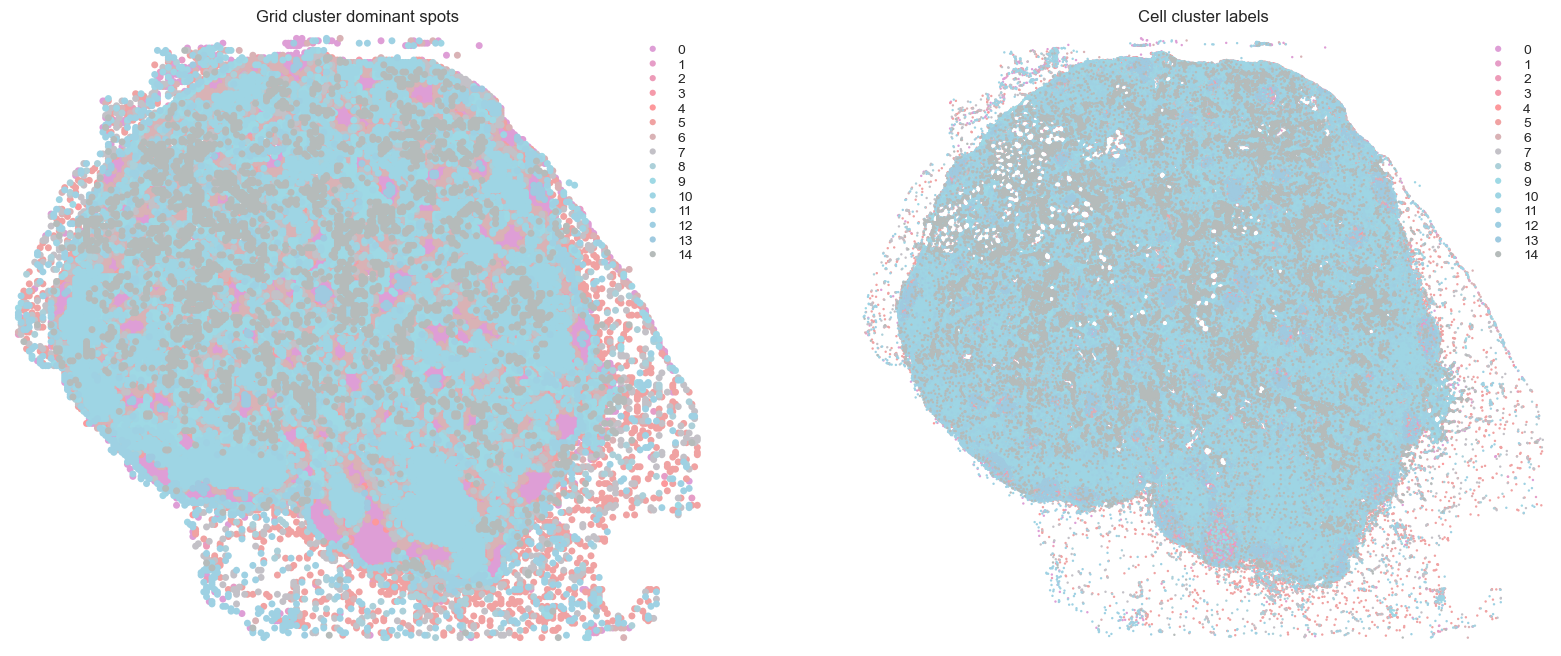

In [99]:
# color shuffle is not working
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import random
palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")
random.shuffle(palette)
cmap = LinearSegmentedColormap.from_list(name= "test",colors = palette)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
st.pl.cluster_plot(grid, use_label='cluster', size=25, ax=axes[0], show_plot=False)
st.pl.cluster_plot(andata, use_label='cluster',size=3, ax=axes[1], show_plot=False)
axes[0].set_title(f'Grid cluster dominant spots')
axes[1].set_title(f'Cell cluster labels')
plt.show()

In [10]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

2293


In [11]:
# Running the analysis #
st.tl.cci.run(grid, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=10000, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=None, # Number of CPUs for parallel. If None, detects & use all available.
                  )

Calculating neighbours...
0 spots with no neighbours, 1 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 260 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████████████████████████████████████████ [ time left: 00:00 ]



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [13]:
grid.uns['lr_summary']

n_spots  n_spots_sig  n_spots_sig_pval
CCN2_LRP1     10545          694              1931
APP_LRP1      24423          648              3405
THBS1_LRP1    22361          555              2855
THBS1_CD36    23069          539              3106
CCN1_ITGB5    13794          529              2858
...             ...          ...               ...
PENK_OPRD1       49            2                49
F2_THBD          51            1                48
NGF_NTRK1        58            1                58
F2_GP1BA         56            0                55
PTH_PTH1R       235            0               230

[268 rows x 3 columns]

In [26]:
import pickle
with open(os.path.join(pathout,"grid_uns_mtracies.pkl"), 'wb') as buff:
     pickle.dump({'grid_counts':grid.uns['grid_counts'], 'grid_xedges':grid.uns['grid_xedges'], 'grid_yedges':grid.uns['grid_yedges']}, buff)

In [19]:
grid.uns['lrfeatures']

nonzero-median zero-prop median_rank prop_rank mean_rank  \
NTF3_NTRK1               0.591079  0.965526           0         0       0.0   
FGF23_FGFR3              0.610628  0.965455           5         1       3.0   
EDIL3_ITGB3                0.6071  0.945633           1         7       4.0   
FGF4_FGFR3                0.61492  0.963929           7         3       5.0   
L1CAM_PTPRZ1             0.610484  0.939063           4         9       6.5   
...                           ...       ...         ...       ...       ...   
TNFSF13B_TNFRSF13C       2.065168  0.318913         258       250     254.0   
GRN_TNFRSF1A             1.764599  0.214601         253       258     255.5   
APP_TNFRSF21             1.960506   0.24413         257       255     256.0   
CD59_CD2                 1.942643  0.231527         256       256     256.0   
BTLA_CD79A               3.038341  0.181172         259       259     259.0   

                       L_0.5    L_0.75    L_0.85     L_0.9    L_0.95  ...  \
NTF3_NTRK1          0.000000  0.000000  0.000000  0.000000  0.000000  ...   
FGF23_FGFR3         0.000000  0.000000  0.000000  0.000000  0.000000  ...   
EDIL3_ITGB3         0.000000  0.000000  0.000000  0.000000  0.000000  ...   
FGF4_FGFR3          0.000000  0.000000  0.000000  0.000000  0.000000  ...   
L1CAM_PTPRZ1        0.000000  0.000000  0.000000  0.000000  0.594325  ...   
...                      ...       ...       ...       ...       ...  ...   
TNFSF13B_TNFRSF13C  0.404709  1.015231  1.421386  1.723804  2.239080  ...   
GRN_TNFRSF1A        1.975712  3.286964  4.103847  4.679065  5.563615  ...   
APP_TNFRSF21        2.319909  3.821450  4.799870  5.526956  6.708201  ...   
CD59_CD2            0.833681  1.654739  2.156472  2.543641  3.155113  ...   
BTLA_CD79A          1.518318  2.677080  3.349709  3.814312  4.560585  ...   

                      R_0.85      R_0.9     R_0.95     R_0.97     R_0.98  \
NTF3_NTRK1          0.000000   0.000000   0.000000   0.000000   0.453882   
FGF23_FGFR3         0.000000   0.000000   0.395133   0.609600   0.739328   
EDIL3_ITGB3         0.000000   0.000000   0.520714   0.700036   0.840431   
FGF4_FGFR3          0.000000   0.000000   0.395133   0.609600   0.739328   
L1CAM_PTPRZ1        0.000000   0.000000   0.000000   0.000000   0.523248   
...                      ...        ...        ...        ...        ...   
TNFSF13B_TNFRSF13C  6.856543   8.543989  11.909034  14.202077  15.746007   
GRN_TNFRSF1A        2.028159   2.372509   2.889096   3.273702   3.542750   
APP_TNFRSF21        2.220327   2.689434   3.416260   3.909379   4.305826   
CD59_CD2            4.783246   5.505987   6.590198   7.347177   7.876231   
BTLA_CD79A          8.933372  11.250013  15.737564  18.776049  20.666483   

                       R_0.99    R_0.995   R_0.9975    R_0.999      R_1.0  
NTF3_NTRK1           0.650588   0.843850   1.057909   1.379210   3.628776  
FGF23_FGFR3          0.980829   1.236763   1.472192   1.848071   3.180947  
EDIL3_ITGB3          1.117131   1.406583   1.791759   2.292761   5.759356  
FGF4_FGFR3           0.980829   1.236763   1.472192   1.848071   3.180947  
L1CAM_PTPRZ1         0.695428   0.857824   1.063521   1.445863   2.886089  
...                       ...        ...        ...        ...        ...  
TNFSF13B_TNFRSF13C  17.828403  19.904079  21.665617  23.396927  32.147232  
GRN_TNFRSF1A         3.994397   4.398563   4.852127   5.375004   7.348777  
APP_TNFRSF21         5.092801   5.794161   6.507728   7.252661   9.789368  
CD59_CD2             8.722757   9.532929  10.211327  10.983750  13.963000  
BTLA_CD79A          23.873072  26.866013  29.925613  33.789402  42.277813  

[260 rows x 29 columns]

In [17]:
grid_save = grid.copy()

In [ ]:
grid.uns['lrfeatures']

In [25]:
grid_save.uns['cluster'].to_csv(os.path.join(pathout, "cluster.csv"))
grid_save.uns['lrfeatures'].to_csv(os.path.join(pathout, "lrfeatures.csv"))
grid_save.uns['lr_summary'].to_csv(os.path.join(pathout, "lr_summary.csv"))

In [18]:
#del grid_save.uns['spatial']
del grid_save.uns['grid_counts']

In [19]:
grid_save.write_h5ad(os.path.join(pathout, "grid_save.h5ad"))

TypeError: Can't implicitly convert non-string objects to strings

Above error raised while writing key 'nonzero-median' of <class 'h5py._hl.group.Group'> to /

<center>Display LR results

In [8]:
import cupy as cp
import cupyx
import scanpy as sc
import stlearn as st
import scanpy as sc
import numpy as np
import pandas as pd
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image

In [2]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 

In [3]:
grid = sc.read_h5ad(os.path.join(pathout, "grid_save.h5ad"))
grid

AnnData object with n_obs × n_vars = 35389 × 1500
    obs: 'imagecol', 'imagerow', 'n_cells', 'cluster'
    obsm: '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spatial', 'spot_neigh_bcs', 'spot_neighbours'

In [4]:
from scipy.sparse import csr_matrix
grid.X = csr_matrix(grid.X)

In [5]:
import os
import pickle

file_path = os.path.join(pathout, "grid_uns_mtracies.pkl")

if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as buff:
        grid_uns_mtracies = pickle.load(buff)
else:
    print("File is empty. Cannot load data.")
    grid_uns_mtracies = None

In [6]:
grid_uns_mtracies.keys()

dict_keys(['grid_counts', 'grid_xedges', 'grid_yedges'])

In [9]:
grid.uns = {}
grid.uns['cluster'] = pd.read_csv(os.path.join(pathout, "cluster.csv"))
grid.uns['grid_counts'] = grid_uns_mtracies['grid_counts']
grid.uns['grid_xedges'] = grid_uns_mtracies['grid_xedges']
grid.uns['grid_yedges'] = grid_uns_mtracies['grid_yedges']
grid.uns['lrfeatures'] = pd.read_csv(os.path.join(pathout, "lrfeatures.csv"))
grid.uns['lr_summary'] = pd.read_csv(os.path.join(pathout, "lr_summary.csv"))

In [ ]:
lr_info = grid.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print(lr_info.shape)
print(lr_info)

In [34]:
grid.uns['lr_summary'].index = grid.uns['lr_summary']["Unnamed: 0"]

In [35]:
grid.uns['lrfeatures'].index = grid.uns['lrfeatures']["Unnamed: 0"]

In [30]:
# grid.uns["lr_summary"].index = grid.uns["lr_summary"].index.astype(str)

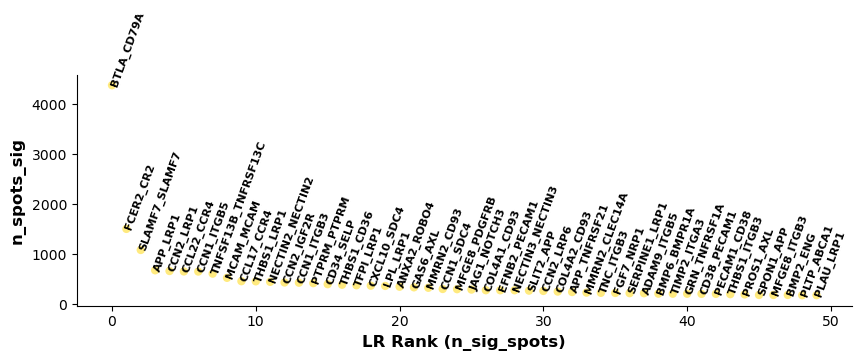

In [36]:
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(grid, n_top=50, figsize=(10,3))

<center>Spatial Stattics Analysis</center>

``` mamba activate squidpy-voyagerpy```

In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd

import scanpy as sc
import voyagerpy as vp
import seaborn as sns
import os
import pickle
from matplotlib.pyplot import imread
from collections import OrderedDict
import json

from matplotlib import pyplot as plt

In [29]:
import zarr
import cupy as cp
import cupyx
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image

import numpy as np
import geopandas as gpd
import pandas as pd

import scanpy as sc
import squidpy as sq
import voyagerpy as vp
import seaborn as sns
import os
import pickle
from matplotlib.pyplot import imread
from collections import OrderedDict
import json
from matplotlib import pyplot as plt

In [30]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 
andata = sc.read_h5ad(os.path.join(pathout, "andata_save.h5ad"))

In [31]:
var_names = andata.var_names.values

In [39]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 
path_xenium = os.path.join(path,"cell_feature_matrix.h5")
path_cells = os.path.join(path,"cells.zarr.zip")
adata = sc.read_10x_h5(path_xenium)
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path))
    return zarr.group(store=store)
root = open_zarr(path_cells)
column_names = dict(root['cell_summary'].attrs.items())['column_names']
def build_obs(andata,root,column_names):
    for i in range(len(column_names)):
        andata.obs[str(column_names[i])] = np.array(root["cell_summary"])[:,i]
    spatial = andata.obs[["cell_centroid_x", "cell_centroid_y"]]
    adata.obsm["spatial"] = spatial.values
    return andata
andata = build_obs(adata,root,column_names)
andata.var_names_make_unique()
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names

In [40]:
sc.pp.subsample(andata,copy=False,n_obs=100_000)
is_mt = andata.var_names.str.startswith('mt')
vp.utils.add_per_cell_qcmetrics(andata, subsets={'mito': is_mt})

In [41]:
visium_spots = gpd.GeoSeries.from_xy(andata.obsm['spatial'][:,0], andata.obsm['spatial'][:,1]).scale(1, 1, origin=(0, 0))
_ = vp.spatial.set_geometry(andata, geom="spot_poly", values=visium_spots)

filter cells based on the rsc analysis

In [42]:
andata = andata[:,var_names].copy()
andata

AnnData object with n_obs × n_vars = 100000 × 1500
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'config'
    obsm: 'spatial', 'geometry'

In [43]:
from scipy.sparse import csr_matrix
andata.X = csr_matrix(andata.X)

In [44]:
vp.utils.log_norm_counts(andata, inplace=True)
andata.X = vp.utils.scale(andata.X, center=True)

In [ ]:
andata.X = csr_matrix(andata.X)

In [45]:
sc.tl.pca(andata, use_highly_variable=False, n_comps=15, random_state=1337)

TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

In [25]:
print(andata.obsm['X_pca'].shape)

(100000, 15)


In [26]:
sc.pp.neighbors(
    andata,
    n_neighbors=25,
    n_pcs=15,
    use_rep='X_pca',
    knn=True,
    random_state=29,
    method='gauss', # one of umap, gauss, rapids
    metric='euclidean', # many metrics available,
    key_added='knn'
)

ValueError: could not broadcast input array from shape (0,) into shape (24,)